In [1]:
import shutil
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
import numpy as np
import matplotlib.pyplot as plt
import wandb
import cv2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import random
import time
import gc
from pathlib import Path
from PIL import Image

In [2]:
# FaceDataset class (unchanged except for removing binary parameter dependency)
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".gif"}

class FaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.my_face_dir = self.root_dir / "my_face"
        self.not_face_dir = self.root_dir / "not_my_face"
        self.paths, self.labels = [], []

        for p in self.my_face_dir.rglob("*"):
            if p.suffix.lower() in IMG_EXTS and p.is_file():
                self.paths.append(p)
                self.labels.append(1)

        for p in self.not_face_dir.rglob("*"):
            if p.suffix.lower() in IMG_EXTS and p.is_file():
                self.paths.append(p)
                self.labels.append(0)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

In [3]:



# TestDataset class (fixed to handle labels properly, assuming test set has same structure)
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.my_face_dir = self.root_dir / "my_face"
        self.not_face_dir = self.root_dir / "not_my_face"
        self.paths, self.labels = [], []

        for p in self.my_face_dir.rglob("*"):
            if p.suffix.lower() in IMG_EXTS and p.is_file():
                self.paths.append(p)
                self.labels.append(1)

        for p in self.not_face_dir.rglob("*"):
            if p.suffix.lower() in IMG_EXTS and p.is_file():
                self.paths.append(p)
                self.labels.append(0)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

In [4]:
# get_transforms (unchanged)
def get_transforms(train=True):
    if train:
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    return transform

In [5]:
# load_vggface_model (unchanged)
def load_vggface_model(num_classes):
    model = models.vgg16(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.classifier = nn.Sequential(
        nn.Linear(512 * 7 * 7, 4096),
        nn.ReLU(True),
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(True),
        nn.Dropout(0.5),
        nn.Linear(4096, num_classes)
    )
    for param in model.classifier.parameters():
        param.requires_grad = True
    for param in model.features[-4:].parameters():
        param.requires_grad = True
    return model

In [6]:
# load_resnet18_from_scratch (unchanged)
def load_resnet18_from_scratch(num_classes):
    model = models.resnet18(pretrained=False)
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(model.fc.in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes)
    )
    return model

In [7]:
# load_resnet18_pretrained (unchanged)
def load_resnet18_pretrained(num_classes):
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

In [8]:
# Updated train_model to handle torch.load with weights_only=True
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25, model_name="model"):
    wandb.init(project="face-recognition", name=model_name)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.1, verbose=True)
    best_acc = 0.0
    best_epoch = 0
    patience = 5

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader
            running_loss = 0.0
            running_corrects = 0
            all_preds = []
            all_labels = []
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            if phase == 'val':
                precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
                recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
                f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
                scheduler.step(epoch_acc)
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Precision: {precision:.4f} Recall: {recall:.4f} F1: {f1:.4f}')
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_epoch = epoch
                    torch.save(model.state_dict(), f"{model_name}_best.pth")
                elif epoch - best_epoch >= patience:
                    print(f'Early stopping at epoch {epoch}')
                    wandb.finish()
                    return model
                wandb.log({
                    f"{phase}_loss": epoch_loss,
                    f"{phase}_acc": epoch_acc,
                    f"{phase}_precision": precision,
                    f"{phase}_recall": recall,
                    f"{phase}_f1": f1,
                    "epoch": epoch,
                    "lr": optimizer.param_groups[0]['lr']
                })
            else:
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                wandb.log({
                    f"{phase}_loss": epoch_loss,
                    f"{phase}_acc": epoch_acc,
                    "epoch": epoch
                })
    wandb.finish()
    return model

In [9]:

# evaluate_model (unchanged)
def evaluate_model(model, test_loader, num_classes, model_name="model"):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f"{model_name}_confusion_matrix.png")
    plt.close()
    return accuracy, precision, recall, f1, cm

In [28]:
import os
import cv2
import torch
import numpy as np
from PIL import Image
from IPython.display import display, HTML
import io
import base64
import wandb
from pathlib import Path

def simulate_phone_lock_images(model, model_name, image_dir, transform, output_dir="output_images", confidence_threshold=0.7, create_video=False, video_fps=10):
    # Check if image directory exists
    if not os.path.exists(image_dir):
        print(f"Image directory not found: {image_dir}")
        return

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    # Create output directory and subdirectory for processed images
    os.makedirs(output_dir, exist_ok=True)
    images_dir = os.path.join(output_dir, f"processed_images_{model_name}")
    os.makedirs(images_dir, exist_ok=True)

    # Load Haar Cascade for face detection
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    if face_cascade.empty():
        print("Error: Could not load Haar Cascade classifier.")
        return

    # Initialize results file
    results_path = os.path.join(output_dir, f"phone_lock_results_{model_name}.txt")
    with open(results_path, 'w') as f:
        f.write("ImageFile,Label,Confidence,RawPrediction,Probabilities\n")

    # Initialize video writer if requested
    video_writer = None
    if create_video:
        # Use first image to determine dimensions
        first_image_path = next((p for p in Path(image_dir).rglob("*") if p.suffix.lower() in {".jpg", ".jpeg", ".png", ".bmp", ".gif"}), None)
        if first_image_path:
            frame = cv2.imread(str(first_image_path))
            height, width = frame.shape[:2]
            output_path = os.path.join(output_dir, f"phone_lock_simulation_{model_name}.mp4")
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            video_writer = cv2.VideoWriter(output_path, fourcc, video_fps, (width, height))
        else:
            print("No images found for video creation. Skipping video output.")
            create_video = False

    # Store sample images for display
    sample_images_html = []
    sample_image_count = 0
    image_count = 0

    # Supported image extensions
    IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".gif"}

    # Process images
    for image_path in Path(image_dir).rglob("*"):
        if image_path.suffix.lower() not in IMG_EXTS or not image_path.is_file():
            continue

        # Read image
        frame = cv2.imread(str(image_path))
        if frame is None:
            print(f"Warning: Could not read image {image_path}")
            continue

        # Validate frame channels
        if frame.ndim != 3 or frame.shape[2] != 3:
            print(f"Warning: Image {image_path.name} has invalid channels ({frame.shape}). Using blank frame.")
            frame = np.zeros((frame.shape[0], frame.shape[1], 3), dtype=np.uint8)

        # Save original image filename
        image_filename = f"image_{image_count:04d}{image_path.suffix}"
        processed_image_path = os.path.join(images_dir, image_filename)
        cv2.imwrite(processed_image_path, frame)  # Save original for reference

        # Convert to grayscale for face detection
        try:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        except cv2.error as e:
            print(f"Error in cvtColor for image {image_path.name}: {e}. Using blank frame.")
            frame = np.zeros((frame.shape[0], frame.shape[1], 3), dtype=np.uint8)
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Detect faces
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        label = "No Face Detected"
        confidence = 0.0
        color = (255, 255, 255)  # White for no face
        raw_prediction = -1
        probabilities_str = "[]"

        if len(faces) > 0:
            # Process the first detected face
            (x, y, w, h) = faces[0]
            # Ensure face region is within frame bounds
            x, y = max(0, x), max(0, y)
            w, h = min(w, frame.shape[1] - x), min(h, frame.shape[0] - y)
            if w <= 0 or h <= 0:
                label = "Invalid Face Region"
                color = (255, 255, 0)  # Yellow
            else:
                face_region = frame[y:y+h, x:x+w]
                # Validate face region channels
                if face_region.ndim != 3 or face_region.shape[2] != 3:
                    print(f"Warning: Face region in image {image_path.name} has invalid channels ({face_region.shape}).")
                    label = "Invalid Face Region"
                    color = (255, 255, 0)
                else:
                    # Convert face region to RGB
                    try:
                        rgb_face = cv2.cvtColor(face_region, cv2.COLOR_BGR2RGB)
                    except cv2.error as e:
                        print(f"Error in cvtColor for face region in image {image_path.name}: {e}.")
                        label = "Invalid Face Region"
                        color = (255, 255, 0)
                        continue
                    pil_image = Image.fromarray(rgb_face)
                    # Apply transform
                    input_tensor = transform(pil_image).unsqueeze(0).to(device)

                    # Make prediction
                    with torch.no_grad():
                        output = model(input_tensor)
                        probabilities = torch.softmax(output, dim=1)
                        confidence, pred = torch.max(probabilities, 1)
                        raw_prediction = pred.item()
                        probabilities_str = f"{probabilities.cpu().numpy().flatten().tolist()}"

                    # Determine label based on prediction
                    if confidence.item() > confidence_threshold:
                        label = "Unlocked" if raw_prediction == 1 else "Locked"
                        color = (0, 255, 0) if raw_prediction == 1 else (0, 0, 255)
                    else:
                        label = "Low Confidence"
                        color = (255, 255, 0)  # Yellow

                    # Draw rectangle around face
                    cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)

        # Log results to file with image filename, including raw prediction and probabilities
        confidence_value = confidence.item() if isinstance(confidence, torch.Tensor) else confidence
        with open(results_path, 'a') as f:
            f.write(f"{image_filename},{label},{confidence_value:.4f},{raw_prediction},{probabilities_str}\n")

        # Add label to frame
        cv2.putText(frame, f"{label} ({confidence_value:.2f})", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

        # Save annotated image
        annotated_image_path = os.path.join(images_dir, f"annotated_{image_filename}")
        cv2.imwrite(annotated_image_path, frame)

        # Write to video if enabled
        if create_video and video_writer is not None:
            video_writer.write(frame)

        # Save sample image for display (up to 3 images with faces)
        if sample_image_count < 3 and len(faces) > 0:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil_frame = Image.fromarray(frame_rgb)
            buffered = io.BytesIO()
            pil_frame.save(buffered, format="JPEG")
            img_str = base64.b64encode(buffered.getvalue()).decode()
            html = f"""
            <div style="text-align: center;">
                <img src="data:image/jpeg;base64,{img_str}" width="224" height="224">
                <p>{label} (Conf: {confidence_value:.2f}) | Image {image_count + 1} | Model: {model_name}</p>
            </div>
            """
            sample_images_html.append(html)
            sample_image_count += 1

        image_count += 1

    # Release resources
    if video_writer is not None:
        video_writer.release()
    print(f"Processed {image_count} images")
    print(f"Saved results: {results_path}")
    print(f"Saved images in: {images_dir}")
    if create_video and video_writer is not None:
        print(f"Saved video: {output_path}")

    # Display sample images in notebook
    if sample_images_html:
        print(f"\nSample images for {model_name}:")
        display(HTML("".join(sample_images_html)))
        # # Log to WandB
        # wandb.log({f"{model_name}_sample_images": [wandb.Html("".join(sample_images_html))]})
    else:
        print(f"No sample images with faces detected for {model_name}")

In [11]:
import os
from PIL import Image
import torch
from torchvision import transforms
import time
from IPython.display import display, clear_output, HTML
import io
import base64

def visualize_test_predictions(models, test_loader, test_transform, class_names=['not_my_face', 'my_face']):
    """
    Visualize predictions on test dataset for each model.
    Args:
        models: List of (model, model_name) tuples.
        test_loader: DataLoader for test dataset.
        test_transform: Transform for model input.
        class_names: List of class names corresponding to labels [0, 1].
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    def get_image_html(img, title):
        """Convert PIL image to HTML with exact size control"""
        buffered = io.BytesIO()
        img.save(buffered, format="JPEG")
        img_str = base64.b64encode(buffered.getvalue()).decode()
        return f"""
        <div style="text-align: center;">
            <img src="data:image/jpeg;base64,{img_str}" width="224" height="224" style="object-fit: contain;">
            <p style="font-family: Arial; font-size: 14px; margin-top: 5px;">{title}</p>
        </div>
        """

    for model, model_name in models:
        print(f"\nInference on test images for {model_name}...\n")
        model.to(device)
        model.eval()
        
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            with torch.no_grad():
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
            
            # Process each image in the batch
            for img, gt_label, pred_label in zip(images, labels, preds):
                # Convert tensor image back to PIL for display
                img = img.cpu().permute(1, 2, 0).numpy()  # [C, H, W] -> [H, W, C]
                img = (img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))  # Denormalize
                img = (img * 255).astype(np.uint8)
                img = Image.fromarray(img)
                
                gt_class = class_names[gt_label.item()]
                pred_class = class_names[pred_label.item()]
                title = f"GT: {gt_class} | Pred: {pred_class} | Model: {model_name}"
                
                # Clear previous output and display
                clear_output(wait=True)
                html_content = get_image_html(img, title)
                display(HTML(html_content))
                time.sleep(0.1)  # Pause for 1 second
        
        print(f"Finished inference for {model_name}!")

In [12]:
# Summarized run_face_recognition (use full version from previous response)
def run_face_recognition():
    # Set random seed
    torch.manual_seed(42)
    random.seed(42)
    np.random.seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Data paths (update these)
    train_dir = "/kaggle/input/vggdataset/Dataset_1/train"
    val_dir = "/kaggle/input/vggdataset/Dataset_1/valid"
    test_dir = "/kaggle/input/vggdataset/Dataset_1/test"

    # Verify paths
    for dir_path in [train_dir, val_dir, test_dir]:
        if not os.path.exists(dir_path):
            raise FileNotFoundError(f"Directory not found: {dir_path}")

    # Create transforms
    train_transform = get_transforms(train=True)
    val_transform = get_transforms(train=False)
    test_transform = get_transforms(train=False)

    # Create datasets
    train_dataset = FaceDataset(train_dir, transform=train_transform)
    val_dataset = FaceDataset(val_dir, transform=val_transform)
    test_dataset = TestDataset(test_dir, transform=test_transform)

    # Compute class weights
    labels = train_dataset.labels
    class_counts = np.bincount(labels)
    weights = 1. / class_counts
    class_weights = torch.tensor(weights, dtype=torch.float)
    sampler_weights = weights[labels]
    sampler = torch.utils.data.WeightedRandomSampler(sampler_weights, len(sampler_weights))

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

    num_classes = 2

    # Initialize models
    print("Initializing VGGFace model...")
    vggface_model = load_vggface_model(num_classes)
    print("Initializing ResNet18 from scratch...")
    resnet_scratch_model = load_resnet18_from_scratch(num_classes)
    print("Initializing ResNet18 pretrained...")
    resnet_pretrained_model = load_resnet18_pretrained(num_classes)

    # Initialize optimizers
    vggface_optimizer = optim.AdamW(vggface_model.parameters(), lr=0.0001, weight_decay=0.01)
    resnet_scratch_optimizer = optim.AdamW(resnet_scratch_model.parameters(), lr=0.001, weight_decay=0.01)
    resnet_pretrained_optimizer = optim.AdamW(resnet_pretrained_model.parameters(), lr=0.0001, weight_decay=0.001)

    # Move class weights to device
    if torch.cuda.is_available():
        class_weights = class_weights.cuda()
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    # Train and evaluate models
    models = [
        (vggface_model, vggface_optimizer, "vggface"),
        (resnet_scratch_model, resnet_scratch_optimizer, "resnet18_scratch"),
        (resnet_pretrained_model, resnet_pretrained_optimizer, "resnet18_pretrained")
    ]

    trained_models = []
    for model, optimizer, model_name in models:
        print(f"\nTraining {model_name}...")
        trained_model = train_model(
            model, criterion, optimizer, train_loader, val_loader,
            num_epochs=25, model_name=model_name
        )
        print(f"\nEvaluating {model_name}...")
        evaluate_model(trained_model, test_loader, num_classes, model_name=model_name)
        trained_models.append((trained_model, model_name))

    return trained_models, test_transform

In [13]:
os.environ["WANDB_API_KEY"] = "b9247d458bf01da8c41dc1f576705259743348e1"
wandb.login()
print("Starting Face Recognition Task...")

wandb: Currently logged in as: rv17richaverma (rv17richaverma-iiit-hyderabad) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Starting Face Recognition Task...


In [14]:
trained_models, test_transform = run_face_recognition()

Initializing VGGFace model...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Initializing ResNet18 from scratch...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Initializing ResNet18 pretrained...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.



Training vggface...


Epoch 0/24
----------


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


train Loss: 0.0670 Acc: 0.9682
val Loss: 3.4296 Acc: 0.7097 Precision: 0.8162 Recall: 0.7097 F1: 0.6867
Epoch 1/24
----------
train Loss: 0.0079 Acc: 0.9966
val Loss: 3.0380 Acc: 0.7868 Precision: 0.8371 Recall: 0.7868 F1: 0.7801
Epoch 2/24
----------
train Loss: 0.0062 Acc: 0.9984
val Loss: 4.1105 Acc: 0.7824 Precision: 0.8460 Recall: 0.7824 F1: 0.7738
Epoch 3/24
----------
train Loss: 0.0020 Acc: 0.9994
val Loss: 3.1609 Acc: 0.7905 Precision: 0.8451 Recall: 0.7905 F1: 0.7835
Epoch 4/24
----------
train Loss: 0.0251 Acc: 0.9953
val Loss: 2.4049 Acc: 0.7701 Precision: 0.7938 Recall: 0.7701 F1: 0.7667
Epoch 5/24
----------
train Loss: 0.0008 Acc: 0.9997
val Loss: 4.7448 Acc: 0.7889 Precision: 0.8478 Recall: 0.7889 F1: 0.7813
Epoch 6/24
----------
train Loss: 0.0002 Acc: 1.0000
val Loss: 4.0678 Acc: 0.7927 Precision: 0.8351 Recall: 0.7927 F1: 0.7873
Epoch 7/24
----------
train Loss: 0.0009 Acc: 0.9994
val Loss: 4.4041 Acc: 0.7916 Precision: 0.8344 Recall: 0.7916 F1: 0.7861
Epoch 8/24
---

epoch,▁▁▂▂▂▂▃▃▄▄▄▄▅▅▅▅▆▆▇▇▇▇█
lr,██████████▁
train_acc,▁▇██▇███████
train_loss,█▂▂▁▄▁▁▁▁▁▁▁
val_acc,▁▇▇█▆███▇█▆
val_f1,▁▇▇█▇███▇█▇
val_loss,▄▃▆▃▁█▆▇▄██
val_precision,▄▇██▁█▆▆▂▇▃
val_recall,▁▇▇█▆███▇█▆
epoch,11
lr,1e-05



Evaluating vggface...
Model: vggface
Accuracy: 0.7189
Precision: 0.8167
Recall: 0.7189
F1 Score: 0.6891

Training resnet18_scratch...


Epoch 0/24
----------


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


train Loss: 0.2874 Acc: 0.8739
val Loss: 1.2114 Acc: 0.5428 Precision: 0.5416 Recall: 0.5428 F1: 0.5383
Epoch 1/24
----------
train Loss: 0.1584 Acc: 0.9382
val Loss: 0.3531 Acc: 0.8449 Precision: 0.8525 Recall: 0.8449 F1: 0.8436
Epoch 2/24
----------
train Loss: 0.1080 Acc: 0.9644
val Loss: 0.8204 Acc: 0.7889 Precision: 0.7916 Recall: 0.7889 F1: 0.7888
Epoch 3/24
----------
train Loss: 0.1496 Acc: 0.9463
val Loss: 1.0814 Acc: 0.7647 Precision: 0.8021 Recall: 0.7647 F1: 0.7589
Epoch 4/24
----------
train Loss: 0.0833 Acc: 0.9729
val Loss: 2.5564 Acc: 0.6220 Precision: 0.7693 Recall: 0.6220 F1: 0.5693
Epoch 5/24
----------
train Loss: 0.0863 Acc: 0.9676
val Loss: 3.7104 Acc: 0.7361 Precision: 0.8085 Recall: 0.7361 F1: 0.7224
Epoch 6/24
----------
train Loss: 0.0739 Acc: 0.9744
val Loss: 2.2067 Acc: 0.6737 Precision: 0.7995 Recall: 0.6737 F1: 0.6402
Early stopping at epoch 6


epoch,▁▁▂▂▃▃▅▅▆▆▇▇█
lr,█████▁
train_acc,▁▅▇▆███
train_loss,█▄▂▃▁▁▁
val_acc,▁█▇▆▃▅
val_f1,▁█▇▆▂▅
val_loss,▃▁▂▃▆█
val_precision,▁█▇▇▆▇
val_recall,▁█▇▆▃▅
epoch,6
lr,0.0001



Evaluating resnet18_scratch...
Model: resnet18_scratch
Accuracy: 0.5256
Precision: 0.5304
Recall: 0.5256
F1 Score: 0.5245

Training resnet18_pretrained...


Epoch 0/24
----------


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


train Loss: 0.0329 Acc: 0.9856
val Loss: 0.2102 Acc: 0.9251 Precision: 0.9288 Recall: 0.9251 F1: 0.9251
Epoch 1/24
----------
train Loss: 0.0014 Acc: 0.9997
val Loss: 0.1791 Acc: 0.9365 Precision: 0.9402 Recall: 0.9365 F1: 0.9364
Epoch 2/24
----------
train Loss: 0.0012 Acc: 1.0000
val Loss: 0.2589 Acc: 0.9187 Precision: 0.9301 Recall: 0.9187 F1: 0.9184
Epoch 3/24
----------
train Loss: 0.0034 Acc: 0.9994
val Loss: 0.1547 Acc: 0.9532 Precision: 0.9540 Recall: 0.9532 F1: 0.9532
Epoch 4/24
----------
train Loss: 0.0040 Acc: 0.9988
val Loss: 0.2741 Acc: 0.8998 Precision: 0.8999 Recall: 0.8998 F1: 0.8998
Epoch 5/24
----------
train Loss: 0.0133 Acc: 0.9956
val Loss: 0.3459 Acc: 0.9047 Precision: 0.9130 Recall: 0.9047 F1: 0.9044
Epoch 6/24
----------
train Loss: 0.0039 Acc: 0.9988
val Loss: 0.4837 Acc: 0.8794 Precision: 0.9021 Recall: 0.8794 F1: 0.8781
Epoch 7/24
----------
train Loss: 0.0006 Acc: 1.0000
val Loss: 0.5072 Acc: 0.8885 Precision: 0.9066 Recall: 0.8885 F1: 0.8877
Epoch 8/24
---

epoch,▁▁▂▂▃▃▄▄▅▅▅▅▆▆▇▇█
lr,███████▁
train_acc,▁███▇▆▇██
train_loss,█▁▁▂▂▄▂▁▁
val_acc,▅▆▅█▃▃▁▂
val_f1,▅▆▅█▃▃▁▂
val_loss,▂▁▃▁▃▅██
val_precision,▅▆▅█▁▃▁▂
val_recall,▅▆▅█▃▃▁▂
epoch,8
lr,1e-05



Evaluating resnet18_pretrained...
Model: resnet18_pretrained
Accuracy: 0.9033
Precision: 0.9176
Recall: 0.9033
F1 Score: 0.9020



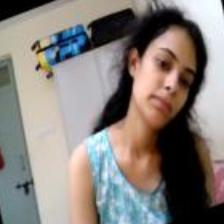

Finished inference for resnet18_pretrained!


In [15]:
test_dir = "/kaggle/input/vggdataset/Dataset_1/test"
test_dataset = TestDataset(test_dir, transform=test_transform)
# Create test loader for visualization (batch_size=1 for sequential display)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)
        
# Visualize test predictions
print("\nVisualizing test predictions...")
visualize_test_predictions(trained_models, test_loader, test_transform)


Simulating phone lock with images...

Simulating phone lock with vggface...
Processed 8 images
Saved results: /kaggle/working/output_images/phone_lock_results_vggface.txt
Saved images in: /kaggle/working/output_images/processed_images_vggface
Saved video: /kaggle/working/output_images/phone_lock_simulation_vggface.mp4

Sample images for vggface:



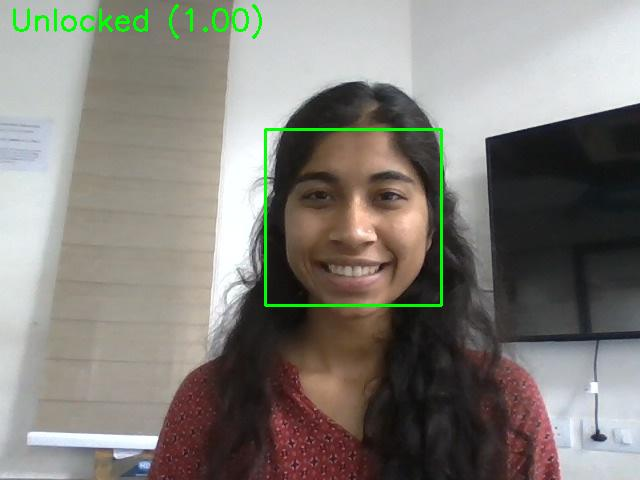
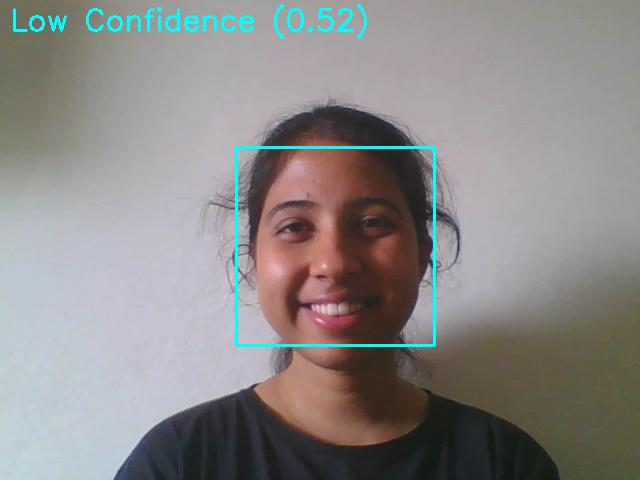
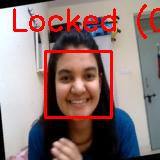


Simulating phone lock with resnet18_scratch...
Processed 8 images
Saved results: /kaggle/working/output_images/phone_lock_results_resnet18_scratch.txt
Saved images in: /kaggle/working/output_images/processed_images_resnet18_scratch
Saved video: /kaggle/working/output_images/phone_lock_simulation_resnet18_scratch.mp4

Sample images for resnet18_scratch:



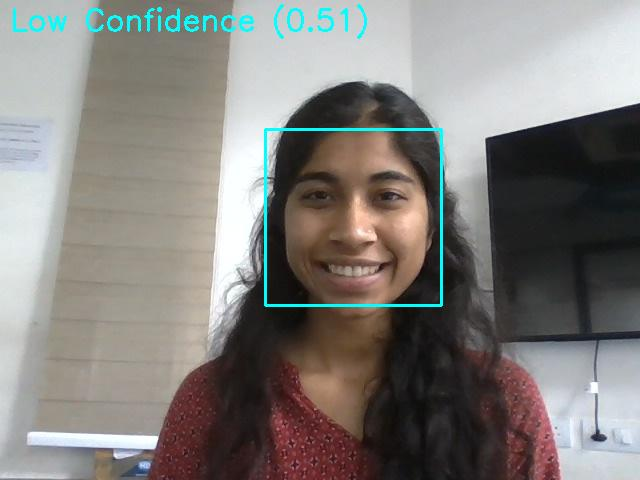
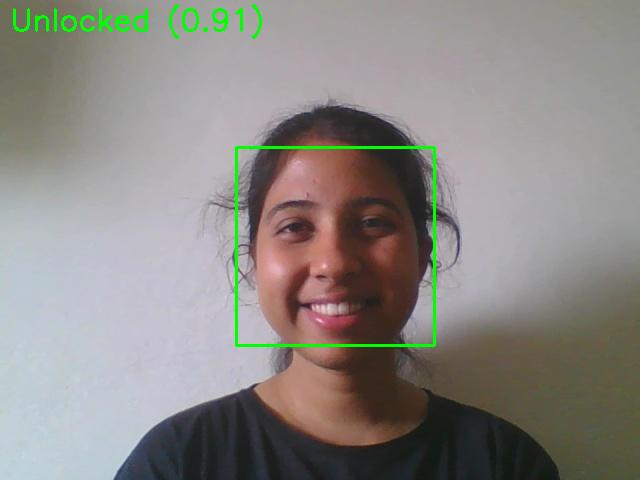
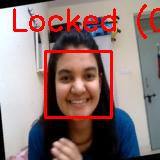


Simulating phone lock with resnet18_pretrained...
Processed 8 images
Saved results: /kaggle/working/output_images/phone_lock_results_resnet18_pretrained.txt
Saved images in: /kaggle/working/output_images/processed_images_resnet18_pretrained
Saved video: /kaggle/working/output_images/phone_lock_simulation_resnet18_pretrained.mp4

Sample images for resnet18_pretrained:



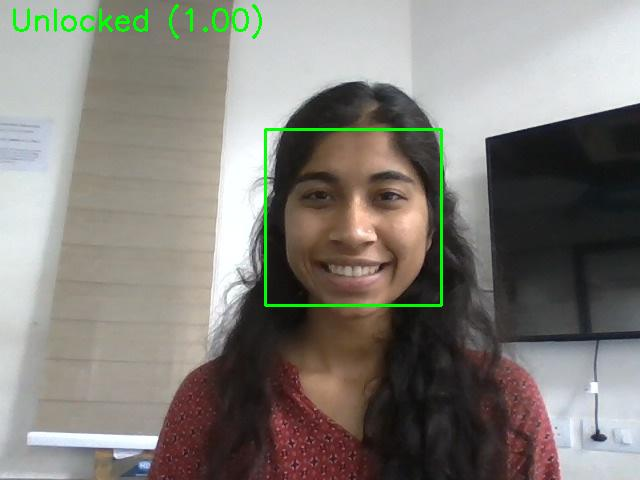
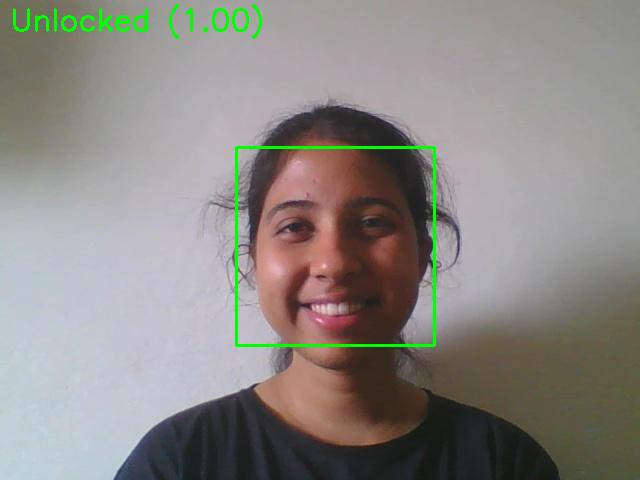
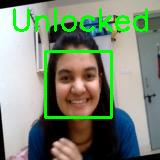


All tasks completed successfully!


In [29]:
# Define image directory
image_dir = "/kaggle/input/phone-screen/sabke_photo"  # Replace with your image directory path
if not os.path.exists(image_dir):
    raise FileNotFoundError(f"Image directory not found: {image_dir}")

# Run phone-lock simulation on images
print("\nSimulating phone lock with images...")
for model, model_name in trained_models:
    print(f"\nSimulating phone lock with {model_name}...")
    # Load best weights
    try:
        model.load_state_dict(torch.load(f"{model_name}_best.pth", weights_only=True))
    except Exception as e:
        print(f"Error loading weights for {model_name}: {e}")
        continue
    simulate_phone_lock_images(
        model=model,
        model_name=model_name,
        image_dir=image_dir,
        transform=test_transform,
        output_dir="/kaggle/working/output_images",
        confidence_threshold=0.7,  # Updated to 0.7
        create_video=True,
        video_fps=10
    )

print("\nAll tasks completed successfully!")